# 基于Transformer的时间序列预测

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 编码-解码器

编码—解码模型主要由编码器和解码器组成，编码器和解码器实际上都是一个神经网络，如下图：

![hello](../images/p24.jpg)

### 编码器

编码器内部由一个输入层和多层RNN（或LSTM）单元构成。

编码器没有输出层，但我们可以将其中RNN的内部状态作为输出。因为经过多层RNN的处理，RNN的内部状态已经可以充分代表源语言的含义。

在一些应用场合，如果将编码器所有神经元的状态都作为编码输出给解码器，复杂度会非常高，因此，人们会将最后一层的编码器状态作为对整个输入信息的编码。之所以选择最后一层，是因为这一层通常是对所有输入信息和低层隐含单元的信息汇总。



![hello](../images/p25.jpg)

### 解码器

解码器的架构和编码器大体相同。

我们已经知道，编码器和解码器之间需要通过内部状态进行连接，我们将内部状态定义为，在完成对中文的编码后编码器内网络全部隐含神经元状态的取值。而在解码器中，我们也定义了相同结构的RNN。因此，我们采用的连接方式是使用编码器RNN的内部状态来初始化解码器RNN的初始状态。实际上，这个过程并非直接采用编码器的输出作为解码器的输入，而是将编码器中每一个神经元的值都直接赋给解码神经元作为初始值。

因此，将解码器的初始状态设定为编码器的最终状态，既可以在编码器与解码器之间建立连接，驱动解码器的运转，又避免了解码器中所有隐含节点被全零初始化或随机初始化，大大节省了训练解码器的时间。

![hello](../images/p26.jpg)

解码器内部的RNN架构与编码器内部的RNN架构相同，我们只需将编码器内部RNN的状态直接赋值给解码器内部的RNN，即可实现内部状态的传递。

解码器与编码器不同的地方在于，解码器需要对应到输出层，也需要使用交叉熵方法来计算网络的损失。由于我们已经将编码器和解码器连接为一个整体的动态计算图，因此神经网络的反馈调整可以由PyTorch自动进行。

我们可以这样理解编码器和解码器的作用：编码器实现的是对源信息的理解，解码器实现的是对内部状态到目标信息的映射，而模型整体可以实现源信息到目标信息的“翻译”。

## 注意力机制

注意力机制的内在规则：将大量注意力分配给少量真正重要的内容。这可以抽象成：给真正重要的信息分配较大的权重，再让信息参与运算，从而得到更有意义的运算结果。

注意力机制在编码—解码模型中的应用是通过引入注意力网络来实现的。注意力网络本身并不复杂，只是一个简单的前馈神经网络，而且一般使用一个隐藏层就足够了，但是它的加入可以训练数据的驱动，为模型提供注意力功能。

引入注意力网络的目的，是在解码过程中为解码器提供关注不同时刻编码器输入信息的能力。具体而言，在中译英任务中，当解码器生成下一个英语单词的时候，我们希望解码器不但能接收当前生成的英语单词作为输入（用于生成序列），还能接收一个表示“在当前状态下，更应该关注编码器的哪个部分”的信息。

注意力网络的输出是一组正实数，加起来等于1。它们是加到编码器各时间步隐含状态上的权重。

在生成权重信息后，我们可以将其与对应的编码器隐含状态做内积（先逐个相乘，再加到一起得到一个向量），这个过程即是对不同中文词语进行加权的过程。加权后再与当前解码器生成的英文单词一同输入解码器。由于此时解码器接收的信息不但包括了当前英文单词，也包括了当前应该关注的中文词语信息，所以解码器可以更准确地生成下一个英文单词。

![hello](../images/p27.jpg)

实际上，在使用PyTorch实现注意力网络的时候，我们的确将整个模型的计算图设计得更为复杂，但是整个计算图依然是相互连接、没有断点的。因此，只需要使用PyTorch的反向传播函数，依然可以对整个模型进行反馈调整。这就是PyTorch动态计算图的强大之处：无论多么复杂的网络模型，只要能生成连贯的计算图，都可以进行自动的反馈调整。现在许多前沿的神经网络研究基于动态计算图的机制，通过改变神经网络的结构来提升运算效果。

## 多变量多步预测模型

### 准备时间序列数据

In [2]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
#数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [4]:
# 构造参数字典
params = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [5]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    for i in range(lookback, len(feature) - delay):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    return torch.as_tensor(X), torch.as_tensor(y)

In [6]:
lookback = 6
delay = 3
X_train, y_train = create_dataset(x_train, y_train, lookback, delay)
X_valid, y_valid = create_dataset(x_valid, y_valid, lookback, delay)
X_test, y_test = create_dataset(x_test, y_test, lookback, delay)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([23367, 7, 2]) torch.Size([23367, 3, 1])
torch.Size([1455, 7, 2]) torch.Size([1455, 3, 1])
torch.Size([1455, 7, 2]) torch.Size([1455, 3, 1])


In [7]:
# 创建训练集和验证集
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                             shuffle=True,
                             batch_size=32)

valid_loader = data.DataLoader(data.TensorDataset(X_valid, y_valid),
                             shuffle=True,
                             batch_size=32)

### 双向LSTM的编码-解码器

除了加入注意力网络之外，还有多种方式去改进编码—解码模型。GRU是LSTM的一种简单变体，可以将它应用到编码—解码模型中。

具体来说，在Seq2Seq模型中：

- 编码器（Encoder）的隐藏状态（encoder_hidden）： 当编码器处理输入序列时，它会生成一个隐藏状态，该隐藏状态包含了输入序列中信息的抽象表示。这个隐藏状态通常用于初始化解码器的隐藏状态。

- 解码器（Decoder）的隐藏状态（decoder_hidden）： 解码器接收编码器的隐藏状态作为初始隐藏状态，并且在解码的过程中动态地更新这个隐藏状态。这个隐藏状态用于生成目标序列。

In [190]:
def train(train_loader, valid_loader, n_epochs, verbose=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Encoder, self).__init__()
            # LSTM层将输入序列映射到隐藏状态空间，双向LSTM
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入LSTM层，返回隐藏状态和细胞状态
            _, (hidden, cell) = self.lstm(x)
            return hidden, cell

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(Decoder, self).__init__()
            # LSTM层将解码器输入映射到隐藏状态空间
            self.lstm = nn.LSTM(output_size, hidden_size, num_layers=1, batch_first=True, bidirectional = True)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_size*2
            self.out = nn.Linear(hidden_size*2, output_size)

        def forward(self, y, hidden, cell):
            # 将输入序列传入LSTM层，返回输出、隐藏状态和细胞状态
            output, (hidden, cell) = self.lstm(y, (hidden, cell))
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden, cell

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_size, hidden_size)
            self.decoder = Decoder(hidden_size, output_size)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden, encoder_cell = self.encoder(x)
            # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
            # 解码器处理目标序列
            decoder_output, _, _ = self.decoder(y, decoder_hidden, decoder_cell)
            return decoder_output

    # 创建模型和优化器
    model = Seq2Seq(input_size=2, hidden_size=20, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 训练和验证
    num_epochs = n_epochs
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # 清空梯度
            optimizer.zero_grad()
            output = model(X_batch, y_batch)
            loss = loss_fn(output, y_batch)
            # 反向传播计算得到每个参数的梯度值
            loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()

        # 在验证集上评估模型性能
        model.eval()
        with torch.no_grad():
            total_valid_loss = 0
            for X_batch, y_batch in valid_loader:
                valid_output = model(X_batch, y_batch)
                valid_loss = loss_fn(valid_output, y_batch)
                total_valid_loss += valid_loss.item() # .item()表示只包含一个元素的tensor中提取值

        avg_valid_loss = total_valid_loss / len(valid_loader)
        if verbose == True:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_valid_loss:.4f}')
    return model

In [39]:
model = train(train_loader, valid_loader, 10, verbose=True)

Epoch [1/10], Valid Loss: 0.0006
Epoch [2/10], Valid Loss: 0.0001
Epoch [3/10], Valid Loss: 0.0000
Epoch [4/10], Valid Loss: 0.0000
Epoch [5/10], Valid Loss: 0.0000
Epoch [6/10], Valid Loss: 0.0000
Epoch [7/10], Valid Loss: 0.0000
Epoch [8/10], Valid Loss: 0.0000
Epoch [9/10], Valid Loss: 0.0000
Epoch [10/10], Valid Loss: 0.0000


In [40]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, 0, -1:] #0表示第一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [41]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler)

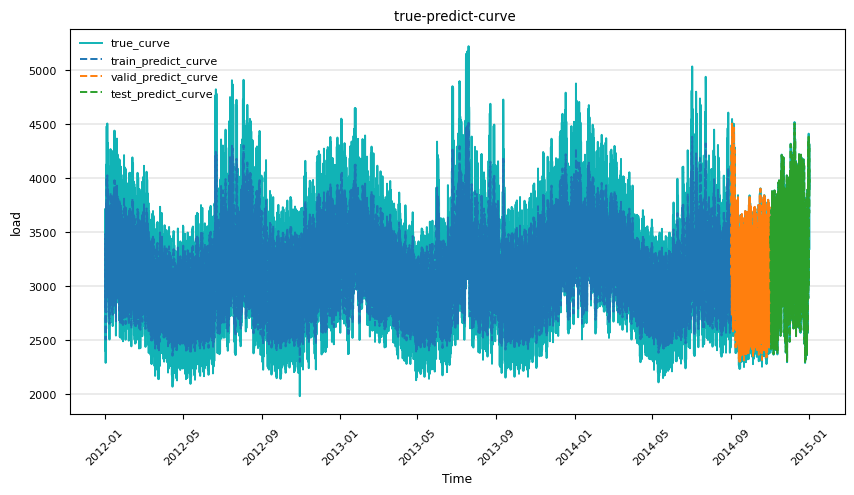

In [42]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()
    
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [44]:
# def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
#     # 准备画布
#     fig = go.Figure()

#     # 添加实际数据
#     fig.add_trace(
#         go.Scatter(
#             x=timeseries_x,
#             y=timeseries_y.reshape(timeseries_y.shape[0], ),
#             mode='lines',
#             name='true_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加训练预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=train_plot_x,
#             y=train_plot_y,
#             mode='lines',
#             name='train_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加验证预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=valid_plot_x,
#             y=valid_plot_y,
#             mode='lines',
#             name='valid_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加测试预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=test_plot_x,
#             y=test_plot_y,
#             mode='lines',
#             name='test_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     #更新图表的排版
#     fig.update_layout(
#         title='true-predict-curve',
#         xaxis=dict(title="date"),
#         yaxis=dict(title="load"),
#         width=900,  #图表宽度
#         height=500,  #图表长度
#         template="simple_white"  #图表风格
#     )

#     fig.show()
    
# #实例化
# plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 双向GRU的编码-解码器

In [145]:
def train(train_loader, valid_loader, n_epochs, verbose=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Encoder, self).__init__()
            # GRU层将输入序列映射到隐藏状态空间，双向GRU
            self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True, bidirectional = True)

        def forward(self, x):
            # 将输入序列传入GRU层，返回隐藏状态
            _, hidden = self.gru(x)
            return hidden

    # 定义解码器模型
    class Decoder(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(Decoder, self).__init__()
            # GRU层将解码器输入映射到隐藏状态空间
            self.gru = nn.GRU(output_size, hidden_size, num_layers=1, batch_first=True, bidirectional = True)
            # dropout操作层
            self.dropout = nn.Dropout(0.1)
            # 线性层将解码器输出映射到指定输出维度，线性层输入维度为hidden_size*2
            self.out = nn.Linear(hidden_size*2, output_size)

        def forward(self, y, hidden):
            print(y.shape)
            # 将输入序列传入GRU层，返回输出、隐藏状态
            output, hidden = self.gru(y, hidden)
            output = self.dropout(output)
            # 使用线性层映射到输出维度
            output = self.out(output)
            return output, hidden

    # 定义整个Seq2Seq模型
    class Seq2Seq(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Seq2Seq, self).__init__()
            # 创建编码器和解码器实例
            self.encoder = Encoder(input_size, hidden_size)
            self.decoder = Decoder(hidden_size, output_size)

        def forward(self, x, y):
            # 编码器处理输入序列
            encoder_hidden = self.encoder(x)
            # 解码器初始化隐藏状态，让解码器的隐藏层状态等于编码器的隐藏层状态
            decoder_hidden = encoder_hidden
            # 解码器处理目标序列
            decoder_output, _ = self.decoder(y, decoder_hidden)
            return decoder_output

    # 创建模型和优化器
    model = Seq2Seq(input_size=2, hidden_size=20, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 训练和验证
    num_epochs = n_epochs
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # 清空梯度
            optimizer.zero_grad()
            output = model(X_batch, y_batch)
            loss = loss_fn(output, y_batch)
            # 反向传播计算得到每个参数的梯度值
            loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()

        # 在验证集上评估模型性能
        model.eval()
        with torch.no_grad():
            total_valid_loss = 0
            for X_batch, y_batch in valid_loader:
                valid_output = model(X_batch, y_batch)
                valid_loss = loss_fn(valid_output, y_batch)
                total_valid_loss += valid_loss.item() # .item()表示只包含一个元素的tensor中提取值

        avg_valid_loss = total_valid_loss / len(valid_loader)
        if verbose == True:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_valid_loss:.4f}')
    return model

In [146]:
model = train(train_loader, valid_loader, 10, verbose=True)

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([15, 3, 1])
Epoch [1/10], Valid Loss: 0.0006
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
t

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([7, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size(

In [54]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, 0, -1:] #0表示第一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [55]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler)

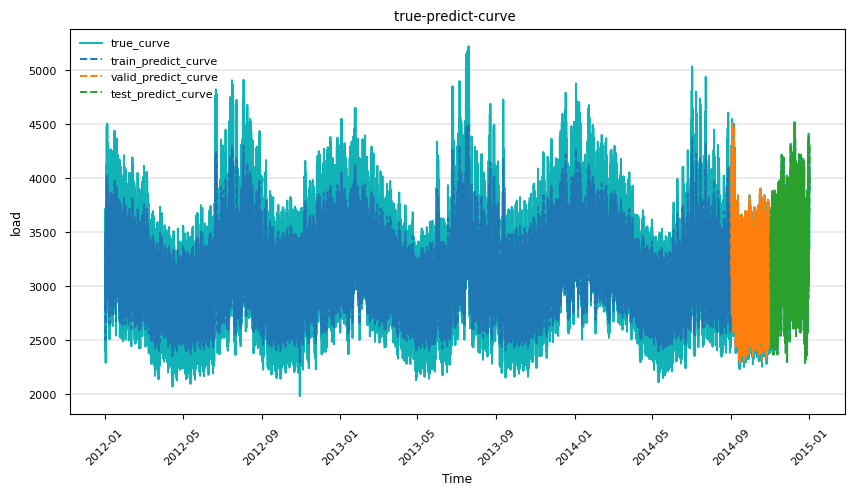

In [56]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()
    
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [58]:
# def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
#     # 准备画布
#     fig = go.Figure()

#     # 添加实际数据
#     fig.add_trace(
#         go.Scatter(
#             x=timeseries_x,
#             y=timeseries_y.reshape(timeseries_y.shape[0], ),
#             mode='lines',
#             name='true_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加训练预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=train_plot_x,
#             y=train_plot_y,
#             mode='lines',
#             name='train_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加验证预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=valid_plot_x,
#             y=valid_plot_y,
#             mode='lines',
#             name='valid_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加测试预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=test_plot_x,
#             y=test_plot_y,
#             mode='lines',
#             name='test_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     #更新图表的排版
#     fig.update_layout(
#         title='true-predict-curve',
#         xaxis=dict(title="date"),
#         yaxis=dict(title="load"),
#         width=900,  #图表宽度
#         height=500,  #图表长度
#         template="simple_white"  #图表风格
#     )

#     fig.show()
    
# #实例化
# plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 单向GRU和注意力机制的编码-解码器

In [77]:
def train(train_loader, valid_loader, n_epochs, verbose=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Encoder, self).__init__()
            # GRU层将输入序列映射到隐藏状态空间
            self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True, bidirectional = False)

        def forward(self, x):
            # 将输入序列传入GRU层，返回隐藏状态
            _, hidden = self.gru(x)
            return hidden

    class Attention(nn.Module):
        def __init__(self, hidden_size):
            super(Attention, self).__init__()
            self.attn = nn.Linear(hidden_size*2, 1)

        def forward(self, decoder_hidden, encoder_outputs):
            # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
            decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

            # 沿着最后一个维度拼接
            cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
            energy = torch.tanh(self.attn(cat_outputs))
            attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
            
            # 计算上下文向量
            context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
            return context, attention_weights

    # 修改解码器模型，加入注意力机制
    class Decoder(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(Decoder, self).__init__()
            self.gru = nn.GRU(output_size, hidden_size, num_layers=1, batch_first=True, bidirectional = False)
            self.out = nn.Linear(hidden_size * 2, output_size)  # 注意：输出维度扩展为 hidden_size * 2
            self.attention = Attention(hidden_size)

        def forward(self, y, hidden, encoder_outputs):
            output, hidden = self.gru(y.view(len(y), 1, -1), hidden)
            # 使用注意力机制获取上下文向量和注意力权重
            context, attention_weights = self.attention(hidden[-1], encoder_outputs)
            # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
            output = self.out(torch.cat((output.view(len(y), -1), context), dim=1))
            return output, hidden, attention_weights

    class Seq2Seq(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Seq2Seq, self).__init__()
            self.encoder = Encoder(input_size, hidden_size)
            self.decoder = Decoder(hidden_size, output_size)

        def forward(self, x, y):
            encoder_hidden = self.encoder(x)

            decoder_hidden = encoder_hidden
            decoder_outputs = []
            for i in range(y.size(1)):  # 遍历序列的每个时间步
                decoder_input = y[:, i, :]
                decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden)
                decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
            return torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接

    # 创建模型和优化器
    model = Seq2Seq(input_size=2, hidden_size=20, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 训练和验证
    num_epochs = n_epochs
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # 清空梯度
            optimizer.zero_grad()
            output = model(X_batch, y_batch)
            loss = loss_fn(output, y_batch)
            # 反向传播计算得到每个参数的梯度值
            loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()

        # 在验证集上评估模型性能
        model.eval()
        with torch.no_grad():
            total_valid_loss = 0
            for X_batch, y_batch in valid_loader:
                valid_output = model(X_batch, y_batch)
                valid_loss = loss_fn(valid_output, y_batch)
                total_valid_loss += valid_loss.item() # .item()表示只包含一个元素的tensor中提取值

        avg_valid_loss = total_valid_loss / len(valid_loader)
        if verbose == True:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_valid_loss:.4f}')
    return model

In [78]:
model = train(train_loader, valid_loader, 10, verbose=True)

Epoch [1/10], Valid Loss: 0.0004
Epoch [2/10], Valid Loss: 0.0001
Epoch [3/10], Valid Loss: 0.0000
Epoch [4/10], Valid Loss: 0.0000
Epoch [5/10], Valid Loss: 0.0000
Epoch [6/10], Valid Loss: 0.0000
Epoch [7/10], Valid Loss: 0.0000
Epoch [8/10], Valid Loss: 0.0000
Epoch [9/10], Valid Loss: 0.0000
Epoch [10/10], Valid Loss: 0.0000


In [79]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, 0, -1:] #0表示第一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [80]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler)

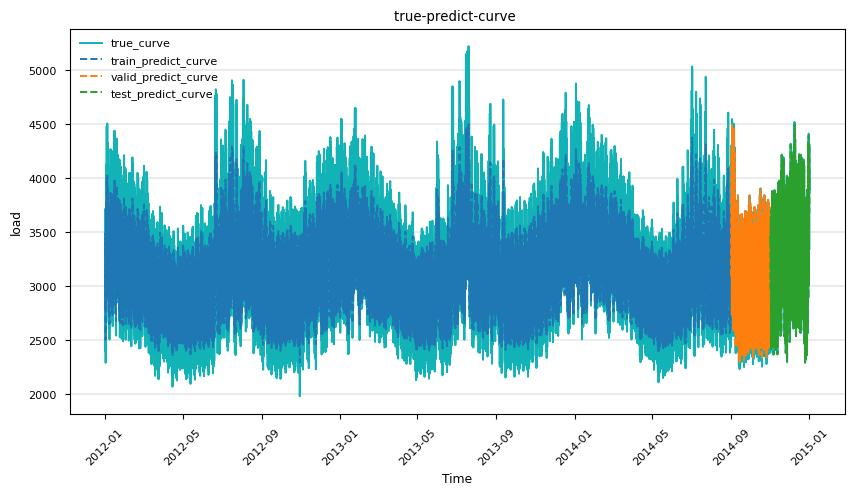

In [94]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()
    
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [76]:
# def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
#     # 准备画布
#     fig = go.Figure()

#     # 添加实际数据
#     fig.add_trace(
#         go.Scatter(
#             x=timeseries_x,
#             y=timeseries_y.reshape(timeseries_y.shape[0], ),
#             mode='lines',
#             name='true_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加训练预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=train_plot_x,
#             y=train_plot_y,
#             mode='lines',
#             name='train_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加验证预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=valid_plot_x,
#             y=valid_plot_y,
#             mode='lines',
#             name='valid_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加测试预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=test_plot_x,
#             y=test_plot_y,
#             mode='lines',
#             name='test_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     #更新图表的排版
#     fig.update_layout(
#         title='true-predict-curve',
#         xaxis=dict(title="date"),
#         yaxis=dict(title="load"),
#         width=900,  #图表宽度
#         height=500,  #图表长度
#         template="simple_white"  #图表风格
#     )

#     fig.show()
    
# #实例化
# plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

### 单向LSTM和注意力机制的编码-解码器

In [8]:
def train(train_loader, valid_loader, n_epochs, verbose=True):
    # 定义编码器模型
    class Encoder(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Encoder, self).__init__()
            # LSTM层将输入序列映射到隐藏状态空间
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True, bidirectional = False)

        def forward(self, x):
            # 将输入序列传入LSTM层，返回隐藏状态
            _, (hidden, cell) = self.lstm(x)
            return hidden, cell

    class Attention(nn.Module):
        def __init__(self, hidden_size):
            super(Attention, self).__init__()
            self.attn = nn.Linear(hidden_size*2, 1)

        def forward(self, decoder_hidden, encoder_outputs):
            # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
            decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

            # 沿着最后一个维度拼接
            cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
            energy = torch.tanh(self.attn(cat_outputs))
            attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
            
            # 计算上下文向量
            context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
            return context, attention_weights

    # 修改解码器模型，加入注意力机制
    class Decoder(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(Decoder, self).__init__()
            self.lstm = nn.LSTM(output_size, hidden_size, num_layers=1, batch_first=True, bidirectional = False)
            self.out = nn.Linear(hidden_size * 2, output_size)  # 注意：输出维度扩展为 hidden_size * 2
            self.attention = Attention(hidden_size)

        def forward(self, y, hidden, cell, encoder_outputs):
            output, (hidden, cell) = self.lstm(y.view(len(y), 1, -1), (hidden, cell))
            # 使用注意力机制获取上下文向量和注意力权重
            context, attention_weights = self.attention(hidden[-1], encoder_outputs)
            # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
            output = self.out(torch.cat((output.view(len(y), -1), context), dim=1))
            return output, hidden, cell, attention_weights

    class Seq2Seq(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Seq2Seq, self).__init__()
            self.encoder = Encoder(input_size, hidden_size)
            self.decoder = Decoder(hidden_size, output_size)

        def forward(self, x, y):
            encoder_hidden, encoder_cell = self.encoder(x)

            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
            decoder_outputs = []
            for i in range(y.size(1)):  # 遍历序列的每个时间步
                decoder_input = y[:, i, :]
                decoder_output, decoder_hidden, _, _ = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden)
                decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
            return torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接

    # 创建模型和优化器
    model = Seq2Seq(input_size=2, hidden_size=20, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 训练和验证
    num_epochs = n_epochs
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # 清空梯度
            optimizer.zero_grad()
            output = model(X_batch, y_batch)
            loss = loss_fn(output, y_batch)
            # 反向传播计算得到每个参数的梯度值
            loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()

        # 在验证集上评估模型性能
        model.eval()
        with torch.no_grad():
            total_valid_loss = 0
            for X_batch, y_batch in valid_loader:
                valid_output = model(X_batch, y_batch)
                valid_loss = loss_fn(valid_output, y_batch)
                total_valid_loss += valid_loss.item() # .item()表示只包含一个元素的tensor中提取值

        avg_valid_loss = total_valid_loss / len(valid_loader)
        if verbose == True:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_valid_loss:.4f}')
    return model

In [9]:
model = train(train_loader, valid_loader, 10, verbose=True)

Epoch [1/10], Valid Loss: 0.0004
Epoch [2/10], Valid Loss: 0.0001
Epoch [3/10], Valid Loss: 0.0000
Epoch [4/10], Valid Loss: 0.0000
Epoch [5/10], Valid Loss: 0.0000
Epoch [6/10], Valid Loss: 0.0000
Epoch [7/10], Valid Loss: 0.0000
Epoch [8/10], Valid Loss: 0.0000
Epoch [9/10], Valid Loss: 0.0000
Epoch [10/10], Valid Loss: 0.0000


In [10]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler):
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        y_pred = model(X_train, y_train)
        y_pred = y_pred[:, 0, -1:] #0表示第一个输出
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        y_pred = model(X_valid, y_valid)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        y_pred = model(X_test, y_test)
        y_pred = y_pred[:, 0, -1:]
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [11]:
y_true = ts_data[['load']]
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, lookback, delay, scaler)

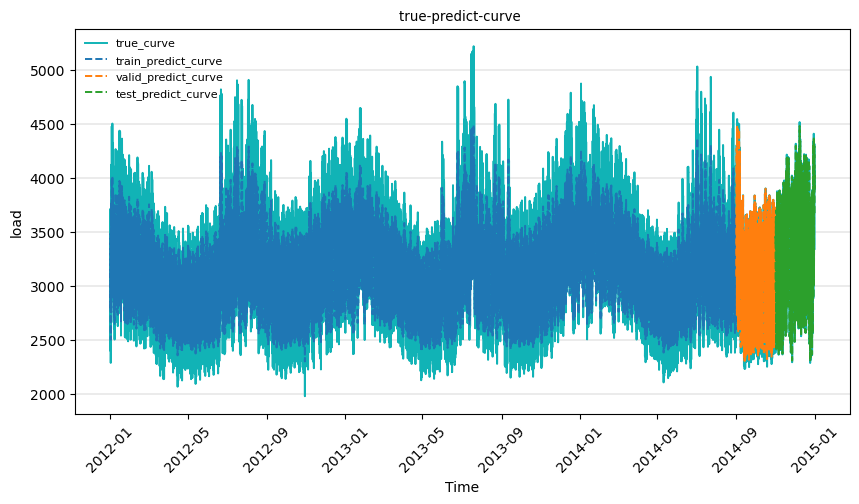

In [12]:
def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
    ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
    ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel(y_true.columns.values[0])
    plt.show()
    
plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)

In [14]:
# def plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
#     # 准备画布
#     fig = go.Figure()

#     # 添加实际数据
#     fig.add_trace(
#         go.Scatter(
#             x=timeseries_x,
#             y=timeseries_y.reshape(timeseries_y.shape[0], ),
#             mode='lines',
#             name='true_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加训练预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=train_plot_x,
#             y=train_plot_y,
#             mode='lines',
#             name='train_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加验证预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=valid_plot_x,
#             y=valid_plot_y,
#             mode='lines',
#             name='valid_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     # 添加测试预测数据
#     fig.add_trace(
#         go.Scatter(
#             x=test_plot_x,
#             y=test_plot_y,
#             mode='lines',
#             name='test_predict_curve',
#             line = dict(color=None, width=2, dash=None)
#         ))

#     #更新图表的排版
#     fig.update_layout(
#         title='true-predict-curve',
#         xaxis=dict(title="date"),
#         yaxis=dict(title="load"),
#         width=900,  #图表宽度
#         height=500,  #图表长度
#         template="simple_white"  #图表风格
#     )

#     fig.show()
    
# #实例化
# plot_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)